In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
from HelperFunctions import *

In [2]:
print(timestmp2sec(sec2timestmp(12)))
print(timestmp2sec("00:01:23"))

12.0
83.0


In [24]:
def getTripTimes(directory):
    zetas = []
    trips = []
    drt_wait_times = []

    for root, subdirs, files in os.walk(directory):
        for file in files:
            if file == "output_trips.csv.gz":
                request = re.match(".*zeta(\d*\.?\d*).*", root)
#                 zetas.append(float(request.group(1).replace("_", ".")))
                zetas.append(float(request.group(1)))
                df = pd.read_csv(
                    os.path.join(root, file), sep=";", compression="gzip"
                ).loc[:, ["person", "trav_time", "wait_time", "modes"]]
                df["trav_time"] = df["trav_time"].apply(timestmp2sec)
                df["wait_time"] = df["wait_time"].apply(timestmp2sec)
                df.set_index("person", inplace=True)
                trips.append(df)
            if file == "0.drt_trips_drt.csv":
                df = pd.read_csv(os.path.join(root, file), sep=";").loc[
                    :, ["personId", "waitTime"]
                ]
                drt_wait_times.append(df.groupby("personId").sum())

    return np.array(zetas), trips, drt_wait_times

In [25]:
from matplotlib import cm
from matplotlib.patches import Patch

modes = {
    'walk-drt-walk': (0, 'drt'),
    'walk-drt-walk-pt-walk-drt-walk': (1, 'drt-pt-drt'),
    'walk-drt-walk-pt-walk-pt-walk-drt-walk': (2, 'drt-pt-pt-drt'),
    '-walk-pt-walk-pt-walk-drt-walk': (2, 'drt-pt-pt-drt'),
}
color_map = cm.plasma(np.linspace(0, 1, 4))

legend_elements = [
    Patch(color=color_map[0], label='drt'),
    Patch(color=color_map[1], label='drt-pt-drt'),
    Patch(color=color_map[2], label='drt-pt-pt-drt'),
    Patch(color=color_map[3], label='other'),
]

def plot_hist(df, g):
    N = 24
    bins = np.linspace(0, 3600, N + 1)
    edges = (bins[1:] + bins[:-1]) / 2
    bar_width = bins[1] - bins[0]
    modes_array = np.zeros(
        (4, N)
    )  # rows correpond to drt, drt-pt-drt, drt-pt-pt-drt & other
    for j in range(N):
        bin_df = df.loc[
            (df["pure_trav_time"] > bins[j])
            & (df["pure_trav_time"] < bins[j + 1]),
            :,
        ]
        mode_count = bin_df.groupby("modes").count()["trav_time"]
        for key, item in mode_count.to_dict().items():
            if key in modes.keys():
                modes_array[modes[key][0], j] = item
            else:
                modes_array[3, j] += item
    bottoms = np.zeros(N)
    for j in range(modes_array.shape[0]):
        plt.bar(
            edges, modes_array[j], color=color_map[j], width=bar_width, bottom=bottoms
        )
        bottoms += modes_array[j]
    plt.xlabel("seconds")
    plt.title("Gamma: {}".format(g))
    plt.legend(handles=legend_elements)

/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/zeta0 <re.Match object; span=(0, 119), match='/home/helge/Applications/matsim/matsim_results_ss>
/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/zeta2.8 <re.Match object; span=(0, 121), match='/home/helge/Applications/matsim/matsim_results_ss>
/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/zeta0.7 <re.Match object; span=(0, 121), match='/home/helge/Applications/matsim/matsim_results_ss>
/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/zeta4.0 <re.Match object; span=(0, 121), match='/home/helge/Applications/matsim/matsim_results_ss>
/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/zeta1.4 <re.Match object; span=(0, 1

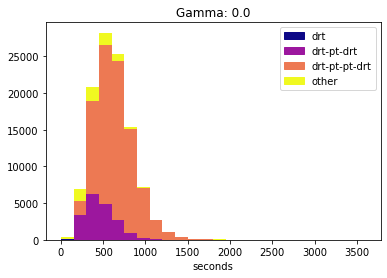

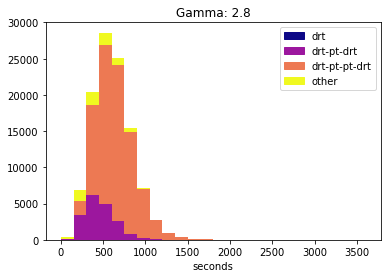

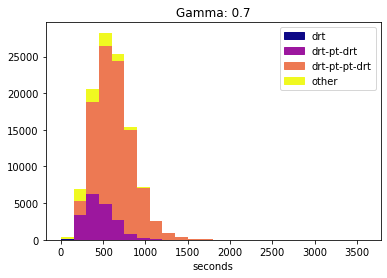

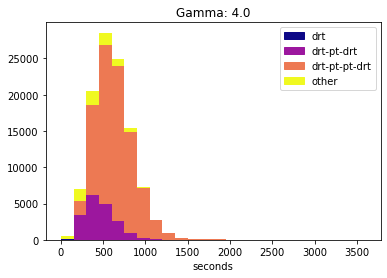

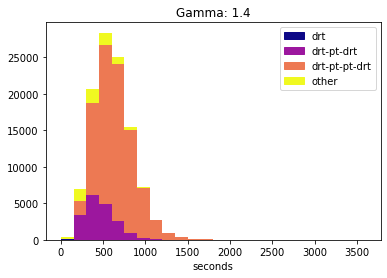

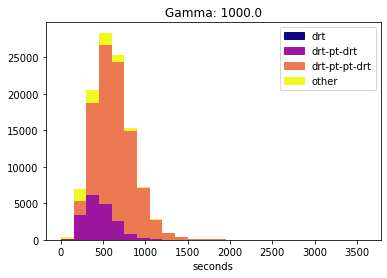

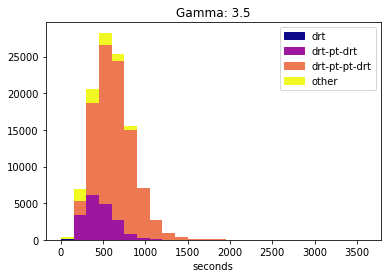

In [26]:
# directory_bim = "/home/helge/Applications/matsim/matsim_results/OwnIntermodalAccEgr/ConvCrit/100000reqs/seed31357/bim_5minTransit_wDiag/"
directory_bim = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/ConvCrit/bim_15min_diag/"
N_trips = 100000


zetas, trip_dfs, drt_wait_times = getTripTimes(directory_bim)

for i, g in enumerate(zetas):
    trip_dfs[i] = (
        trip_dfs[i]
        .groupby("person")
        .agg({"trav_time": np.sum, "wait_time": np.sum, "modes": combineModesSeriesStr})
    )
    print("Zeta: ", g)
    trip_dfs[i]["pure_trav_time"] = trip_dfs[i]["trav_time"] - trip_dfs[i]["wait_time"]
    #     trip_dfs[i]["pure_trav_time"] = (
    #         trip_dfs[i]["pure_trav_time"] + drt_wait_times[i]["waitTime"]
    #     )
    #     trip_dfs[i] = trip_dfs[i][trip_dfs[i]['pure_trav_time'] < 3600]
    mean_time = trip_dfs[i]["pure_trav_time"].mean()
    print(
        "Mean pure travel time: ", mean_time, ", formatted: ", sec2timestmp(mean_time)
    )
    print("ratio of successfull trips: ", len(trip_dfs[i]) / N_trips)
    print("Average wait time: ", drt_wait_times[i]["waitTime"].mean())
    mode_count = trip_dfs[i].groupby("modes").count()["trav_time"]
    print(
        "Pt in trip ratio: ",
        sum([count for key, count in mode_count.to_dict().items() if "pt" in key])
        / mode_count.sum(),
    )
    plt.figure()
    plot_hist(trip_dfs[i], g)
#     plt.savefig('RideTimeDist_zeta{}.png'.format(g))
    print("-------\n")

plt.show()

In [ ]:
directory_drt = "/home/helge/Programs/matsim/matsim_results/OwnIntermodalAccEgr/ConvCrit/100000reqs/seed31357/drt_wDiag/gammaInfty/"
N_trips = 100000

drt_df = pd.read_csv(
    os.path.join(directory_drt, "output_trips.csv.gz"), sep=";", compression="gzip"
).loc[:, ["person", "trav_time", "wait_time", "modes"]]
drt_df["trav_time"] = drt_df["trav_time"].apply(timestmp2sec)
drt_df["wait_time"] = drt_df["wait_time"].apply(timestmp2sec)
drt_df["pure_trav_time"] = drt_df["trav_time"]  - drt_df['wait_time']
drt_df.set_index("person", inplace=True)

# drt_df2 = pd.read_csv('/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/drt/gammaInfty/ITERS/it.0/0.drt_trips_drt.csv', sep=';').loc[:,['personId', 'waitTime', 'travelTime']]
# drt_df2 = drt_df2.groupby('personId').sum()
# drt_df['pure_trav_time'] = drt_df['pure_trav_time'] + drt_df2['waitTime']

print("ratio of successfull trips: ", len(drt_df) / N_trips)
print("Mean pure travel time: ", drt_df["pure_trav_time"].mean())
print("Mean wait time: ", drt_df["wait_time"].mean())

# drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600), color=[cm.rainbow(c) for c in np.linspace(0,1,28)])
# bla = drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600), color=color_map)
plt.figure()
plot_hist(drt_df, r"$\infty$")
# plt.savefig('RideTimeDist_gammaInfty.png')
plt.show()

### Check if access/egress legs do have different waiting time distributions

In [ ]:
path = "/home/helge/Programs/matsim/matsim_results/OwnIntermodalAccEgr/100000reqs/seed31357/bim/gamma1_4/ITERS/it.0/0.drt_trips_drt.csv"
# path = "/home/helge/Programs/matsim/matsim_results/ConvCrit/115997reqs/seed42/bim_ext/gamma0_7/ITERS/it.0/0.drt_trips_drt.csv"

df = pd.read_csv(path, sep=';')
df = df.sort_values(['personId', 'arrivalTime'])
# mask = df[['personId','arrivalTime']].groupby('personId').count()==1
# df = df[df['personId'].isin(mask[~mask].dropna().index)]
# df_access = df.iloc[::2,:]
# df_egress = df.iloc[1::2,:]

plt.hist(df['waitTime'], range=(0,3600), bins=24)

plt.show()

In [ ]:
for i in range(24):
    plt.figure()
    plt.hist(
        df[(df["departureTime"] > i * 3600) & (df["departureTime"] < (i + 1) * 3600)][
            "waitTime"
        ],
        range=(0, 3600),
        bins=24,
    )
    plt.title("{} - {}".format(i,i+1))
# plt.hist(df['waitTime'], range=(0, 3600), bins=24)
# display(df[(df['waitTime'] > 0) & (df['waitTime']) < 150])

plt.show()